In [1]:
from gensim.models import KeyedVectors

fr_embeddings = KeyedVectors.load_word2vec_format("wiki.multi.fr.vec")
en_embeddings = KeyedVectors.load_word2vec_format("wiki.multi.en.vec")


from gensim.models import KeyedVectors
import numpy as np

ar_embeddings = KeyedVectors.load_word2vec_format("wiki.multi.ar.vec", limit=50000)

# Pad the vectors with zeros to match the desired dimensionality (300 in this case)
vector_size = 300
new_vectors = np.zeros((len(ar_embeddings.key_to_index), vector_size))
for word, idx in ar_embeddings.key_to_index.items():
    if len(ar_embeddings.get_vector(word)) == vector_size:
        new_vectors[idx] = ar_embeddings.get_vector(word)
    else:
        print(f"Skipping word '{word}' with vector size {len(ar_embeddings.get_vector(word))}")
ar_embeddings.vectors = new_vectors
ar_embeddings.vector_size = vector_size

In [2]:
import nltk
import numpy as np
from wordfreq import word_frequency
from sklearn.decomposition import TruncatedSVD


def compute_sentence_embeddings(questions, word_embeddings, language, a=0.001): 
    
    question_embeddings = []
    for question in questions: 
        tokens = [t.lower() for t in nltk.word_tokenize(question)]
        tokens = [token for token in tokens if token in word_embeddings]

        weights = [a/(a+word_frequency(token, language)) for token in tokens]
        embedding = np.average([word_embeddings[token] for token in tokens], axis=0, weights=weights)
        question_embeddings.append(embedding)
        
    return question_embeddings

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split


In [4]:

df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')

# Apply sentence embeddings to first column of dataframe
reviews = df.iloc[:, 0].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['English_Embeddings'] = reviews_embeddings
df['sentiment_binary'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Separate the input features (sentence embeddings) and output labels (sentiment)
X = np.vstack(df["English_Embeddings"])  # input features (sentence embeddings)
y = df["sentiment_binary"]  # output labels (sentiment)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
import tensorflow as tf
# Define a model using the Keras API


model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, input_dim=300, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Train English Model
snn = model.fit(X_train, y_train, epochs = 11, 
          batch_size = 32, shuffle=True, 
          validation_data=(X_test, y_test))



Epoch 1/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5092 - accuracy: 0.7626 - val_loss: 0.4240 - val_accuracy: 0.8124
Epoch 2/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.4044 - accuracy: 0.8213 - val_loss: 0.4173 - val_accuracy: 0.8084
Epoch 3/11
1250/1250 [==============================] - 2s 2ms/step - loss: 0.3884 - accuracy: 0.8286 - val_loss: 0.3933 - val_accuracy: 0.8220
Epoch 4/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3791 - accuracy: 0.8339 - val_loss: 0.3777 - val_accuracy: 0.8347
Epoch 5/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3750 - accuracy: 0.8372 - val_loss: 0.3853 - val_accuracy: 0.8282
Epoch 6/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3724 - accuracy: 0.8366 - val_loss: 0.3743 - val_accuracy: 0.8354
Epoch 7/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3667 - accuracy: 0.8402 - val_loss: 0.4018 - val_accuracy:

In [6]:
from sklearn.metrics import classification_report

# Evaluate the performance of the model on the testing set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))

313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      4961
           1       0.78      0.92      0.84      5039

    accuracy                           0.83     10000
   macro avg       0.84      0.82      0.82     10000
weighted avg       0.84      0.83      0.82     10000



[[3630 1331]
 [ 415 4624]]


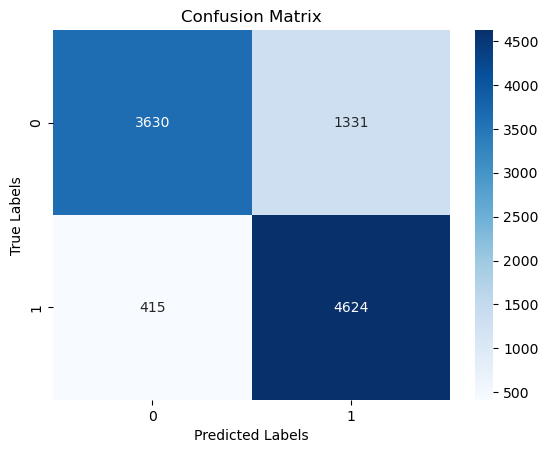

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

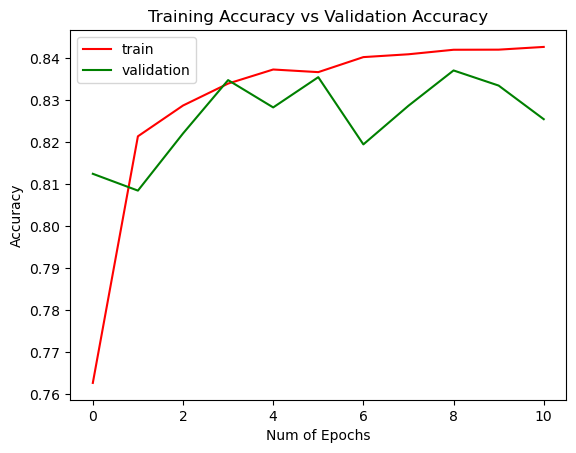

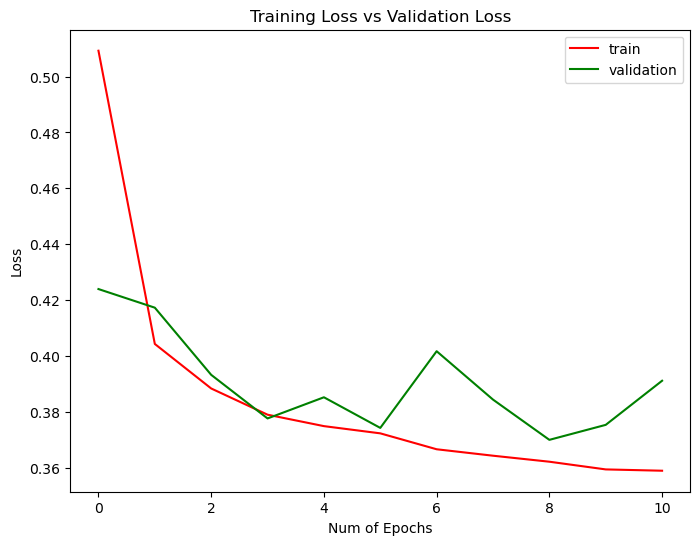

In [8]:
import matplotlib.pyplot as plt
print(snn)

# Results
plt.figure(0)  
plt.plot(snn.history['accuracy'],'r')  
plt.plot(snn.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(snn.history['loss'],'r')  
plt.plot(snn.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()

In [9]:
model.save("CrossLnigualModel_MonoLingualEmbedding_WithOutFineTune.h5")

C:\Users\ALI\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Arabic

In [10]:
df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return 0
    elif rating in [4, 5]:
        return 1
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings
X_test = np.vstack(df['arabic_Embeddings']) 
y_test = df['sentiment']
y_pred = model.predict(X_test)

# create a binary array where values greater than 0.65 are set to 1 and values less than or equal to 0.65 are set to 0
bin_y_pred = np.where(y_pred > 0.5, 1, 0)

# print the resulting binary arraya
print(bin_y_pred)
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, bin_y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, bin_y_pred))

5/5 [==============================] - 0s 3ms/step
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Accuracy: 0.51875
              precision    recall  f1-score   support

           0       0.80      0.05      0.09        80
           1       0.

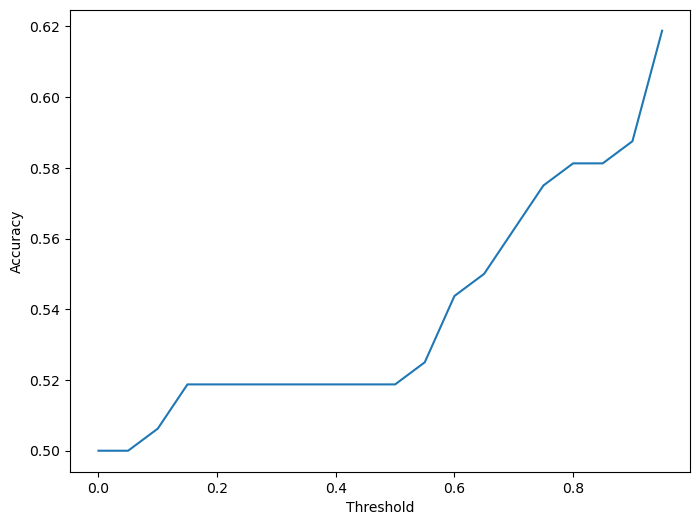

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# create a sample binary array and corresponding true labels
bin_arr = y_pred
labels = y_test

# define a range of threshold values to test
thresholds = np.arange(0, 1.0, 0.05)

# calculate the accuracy for each threshold value
accuracies = []
for threshold in thresholds:
    pred_labels = np.where(bin_arr > threshold, 1, 0)
    accuracy = accuracy_score(labels, pred_labels)
#     print(accuracy)
    accuracies.append(accuracy)

# plot the threshold values against the accuracies
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

In [12]:
# Find the maximum accuracy
max_accuracy = max(accuracies)

# Find the corresponding threshold value for the maximum accuracy
max_threshold = thresholds[accuracies.index(max_accuracy)]

# Print the maximum accuracy and corresponding threshold value
print("Maximum accuracy:", max_accuracy)
print("Corresponding threshold value:", max_threshold)

Maximum accuracy: 0.61875
Corresponding threshold value: 0.9500000000000001


In [13]:
# Evaluate the performance of the model on the testing set
y_pred = model.predict(X_test)
y_pred = (y_pred > max_threshold).astype(int)
print(classification_report(y_test, y_pred))

5/5 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.88      0.28      0.42        80
           1       0.57      0.96      0.72        80

    accuracy                           0.62       160
   macro avg       0.73      0.62      0.57       160
weighted avg       0.73      0.62      0.57       160



[[22 58]
 [ 3 77]]


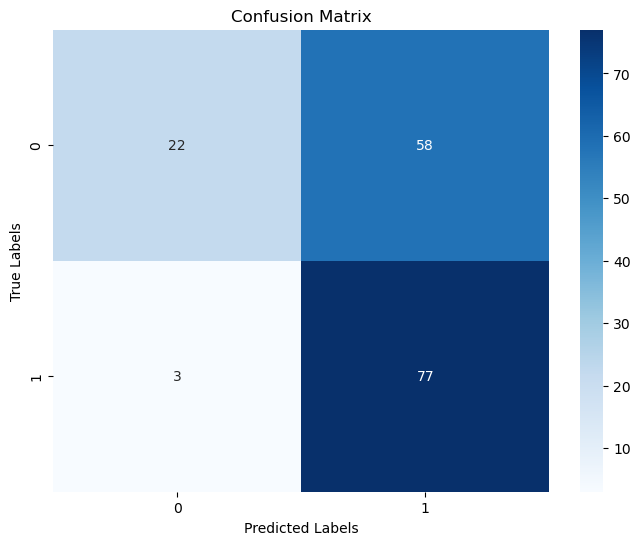

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# French

In [15]:
import pandas as pd

# Load the entire dataset into a DataFrame
df = pd.read_csv('C:/Users/ALI/Desktop/French Dataset/french_tweets.csv')

# Split the dataset into two separate DataFrames by class
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample = sample.head(500)

# Apply sentence embeddings to first column of dataframe
reviews = final_sample['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample['french_Embeddings'] = reviews_embeddings

X_test = np.vstack(final_sample['french_Embeddings']) 
y_test = final_sample['label']
y_pred = model.predict(X_test)


16/16 [==============================] - 0s 2ms/step


C:\Users\ALI\AppData\Local\Temp\ipykernel_11788\1285091986.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sample['french_Embeddings'] = reviews_embeddings


In [16]:
y_pred

array([[2.28905422e-03],
       [7.44703293e-01],
       [4.06838506e-01],
       [1.24233691e-02],
       [4.25189346e-01],
       [2.56071746e-01],
       [5.09882085e-02],
       [1.35255441e-01],
       [8.77117991e-01],
       [8.95385742e-01],
       [4.16446012e-03],
       [1.07585557e-01],
       [6.98528230e-01],
       [7.04814792e-01],
       [1.34805338e-02],
       [2.15249717e-01],
       [9.98003125e-01],
       [5.91629446e-01],
       [4.84282384e-03],
       [9.85629141e-01],
       [7.75862098e-01],
       [9.99736845e-01],
       [9.97458577e-01],
       [6.34955883e-01],
       [4.07166928e-02],
       [8.83008420e-01],
       [9.99316275e-01],
       [9.76123810e-01],
       [6.50596499e-01],
       [9.19508576e-01],
       [9.28107440e-01],
       [9.35913146e-01],
       [9.77325559e-01],
       [9.95244920e-01],
       [6.01620190e-02],
       [9.60490823e-01],
       [1.19561749e-02],
       [1.62170199e-03],
       [2.06408575e-02],
       [1.48326037e-02],


In [17]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
# create a LabelEncoder object
le = LabelEncoder()

# example threshold value
threshold = 0.5
# convert values to binary using threshold
binary_y_pred = np.where(y_pred > threshold, 1, 0)

print(binary_y_pred)
# convert values to binary using threshold
binary_y_test = le.fit_transform(y_test)
binary_y_test

[[0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]


array([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,

In [18]:
accuracy = accuracy_score(binary_y_test, binary_y_pred)
print("Accuracy:", accuracy)

print(classification_report(binary_y_test, binary_y_pred))

Accuracy: 0.606
              precision    recall  f1-score   support

           0       0.61      0.60      0.60       250
           1       0.60      0.62      0.61       250

    accuracy                           0.61       500
   macro avg       0.61      0.61      0.61       500
weighted avg       0.61      0.61      0.61       500



[[149 101]
 [ 96 154]]


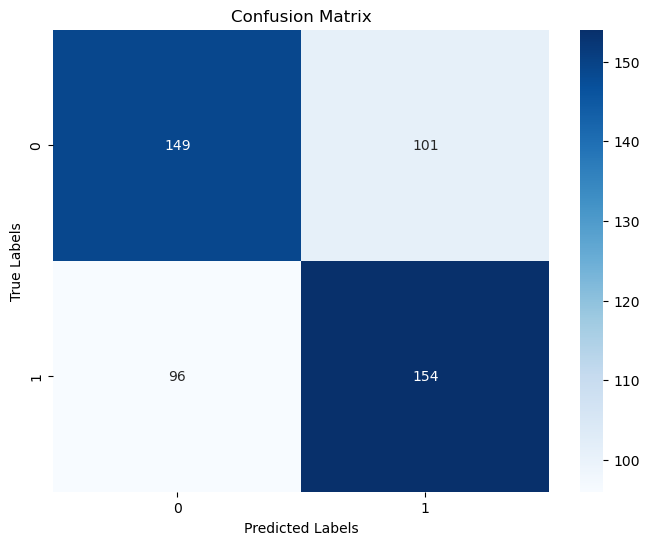

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(binary_y_test, binary_y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()